In [1]:
import IPython.core.display as di
# This line will hide code by default when the notebook is exported as HTML
di.display_html(
    '''
    <script>
      jQuery(
        function() {
          if (jQuery("body.notebook_app").length == 0) { 
            jQuery(".input_area").toggle();
            jQuery(".prompt").toggle();
          }
        }
      );
    </script>''',
    raw=True
)
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html(
    '''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''',
    raw=True
)

Toggle code

# Predicting client default status using continuous and categorical features
##  An Extreme Gradient Boost Classification model
##### by Antonio E. Amador
##### May 5, 2020
#  

## Summary
#### In this excercise, we are required to fit a model to a dataset that contains both continuous and categorical features in order to predict a binary target variable (default).
#### This means we will use supervised machine learning algorithms in order to predict our target variable for a training set and test this model using a test set.
#### Since our target variable is binary it means this is a classification problem; therefore, we will start implementing very simple Logistic Regression and Random Forest models.
#### After defining a metric and evaluating these results, we will move to more complex models that are able to fit the data better and tune the model's parameters to achieve an above 98% performance metric for our training dataset predictions.
#### Neural networks are not considered in this excercise since boosting algorithms are better suited for limited training data and time.
#### Finally, we will predict the default status and default probability for the validation dataset provided and calculate estimated losses for this set

##  
##  
## Importing libraries

In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score

from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Importing data
#### Looking at the array's data types

In [3]:
df = pd.read_csv("default_dataset.csv")
df.dtypes

ID           int64
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
default      int64
dtype: object

## Looking at  the data
#### Take a closer look at "Categories"

In [4]:
df.isna().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

In [5]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000,...,27999.000000,27999.000000,27999.000000,27999.000000,2.799900e+04,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000
mean,15749.304368,169647.833137,1.607522,1.853888,1.552484,35.484696,-0.063324,-0.169327,-0.201900,-0.248009,...,43501.129397,40427.848780,38988.426658,5823.589878,6.107637e+03,5383.826137,4951.663381,4878.592700,5342.790350,0.165613
std,8452.091410,130240.416104,0.488311,0.795310,0.521850,9.168462,1.088628,1.162094,1.158822,1.139461,...,64547.035637,60932.675754,59691.059489,16926.065931,2.362333e+04,17997.627313,16023.404493,15329.242967,17990.023991,0.371740
min,3.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8999.500000,60000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2373.000000,1809.000000,1278.000000,1000.000000,1.000000e+03,457.000000,316.000000,298.500000,188.000000,0.000000
50%,15999.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19097.000000,18106.000000,17021.000000,2184.000000,2.078000e+03,1917.000000,1520.000000,1548.000000,1500.000000,0.000000
75%,22998.500000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,55154.500000,50437.500000,49380.000000,5100.000000,5.000000e+03,4730.000000,4162.000000,4181.500000,4133.500000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


#### Dropping ID column as it does not add any information to the model

In [6]:
df = df.drop(['ID'], axis=1)

#### In this boxplots we can easily identify continuous and categorical variables

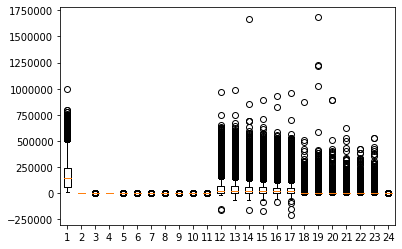

In [7]:
df_temp = df.iloc[:,:]
for i in range(1):
    fig, ax = plt.subplots()
    mask = ~np.isnan(df_temp.values)
    filtered_data = [d[m] for d, m in zip(df_temp.values.T, mask.T)]
    ax.boxplot(filtered_data)
    plt.show()

## Categorical features

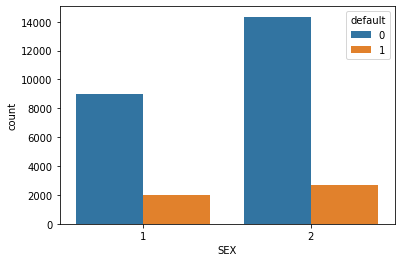

In [8]:
sns.countplot(x='SEX', hue='default', data=df)

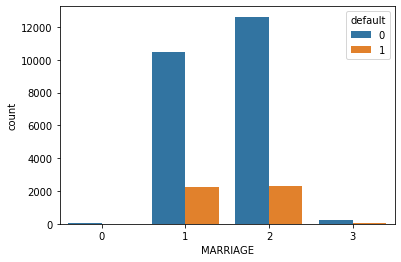

In [9]:
sns.countplot(x='MARRIAGE', hue='default', data=df)

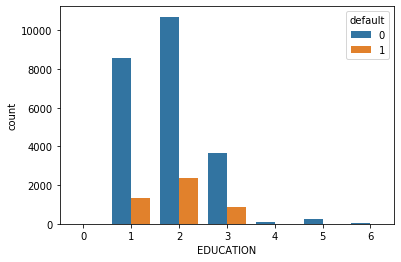

In [10]:
sns.countplot(x='EDUCATION', hue='default', data=df)

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']


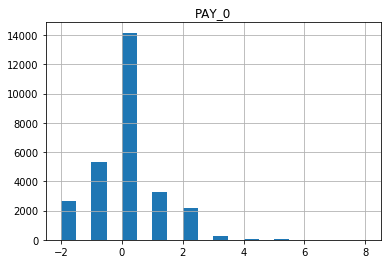

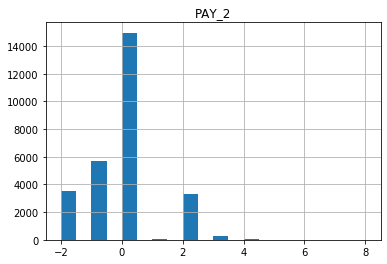

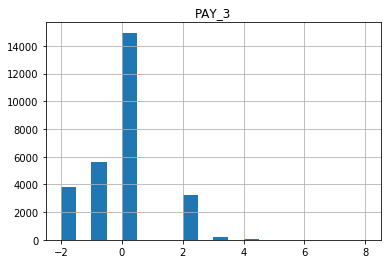

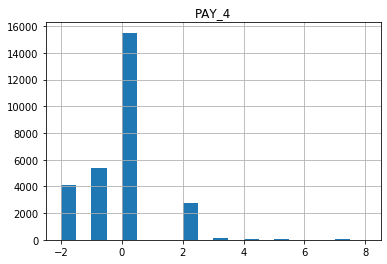

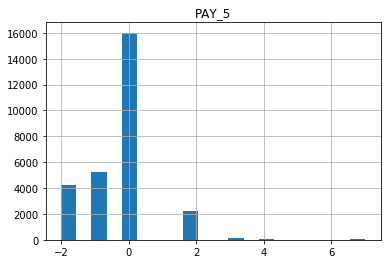

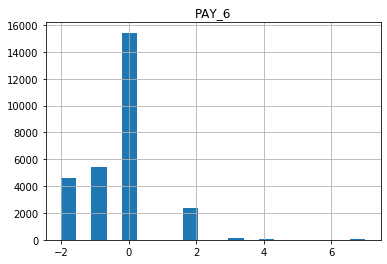

In [11]:
plt.rcParams.update({'figure.max_open_warning': 0}) #deactivate warning

df_temp = df.iloc[:,5:11]
columns = df_temp.columns.values.tolist()
print(columns)
    
for i in columns:
    df.hist(column=i, bins=20)

## Continuous features

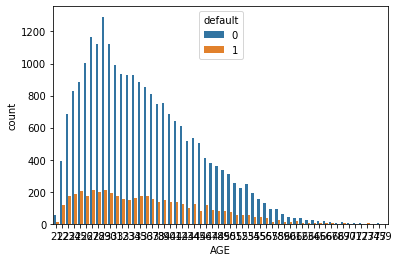

In [12]:
sns.countplot(x='AGE', hue='default', data=df)

['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


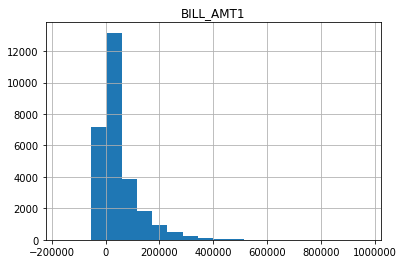

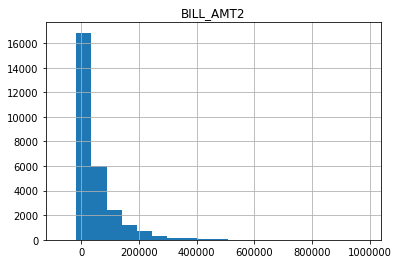

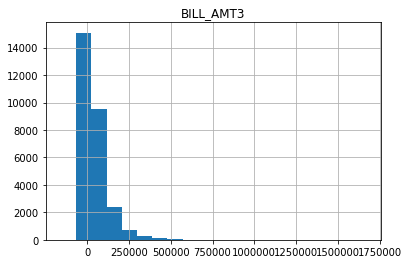

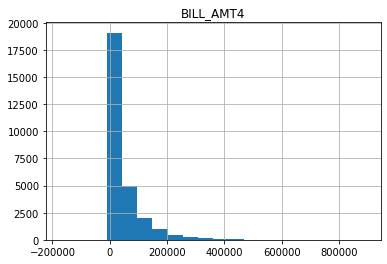

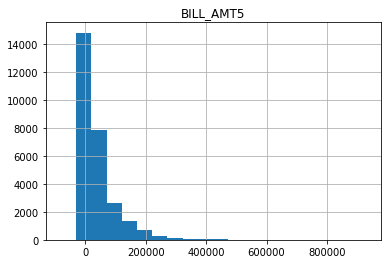

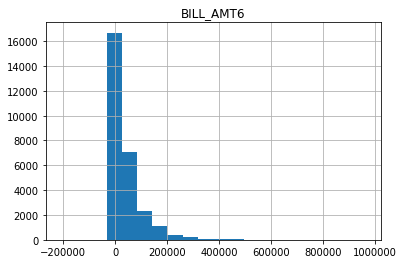

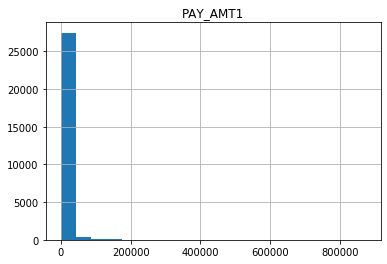

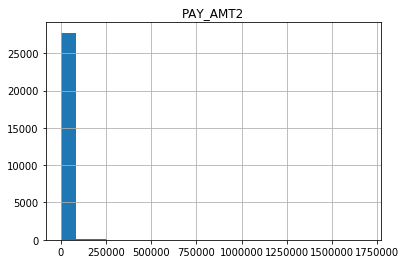

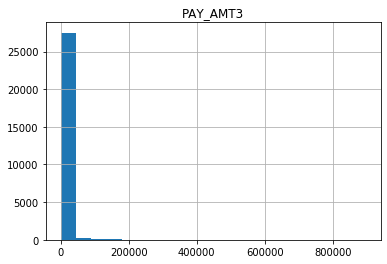

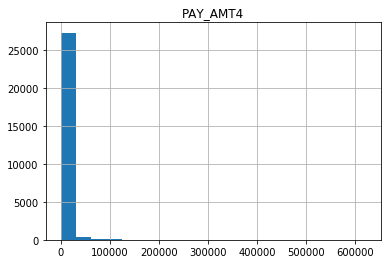

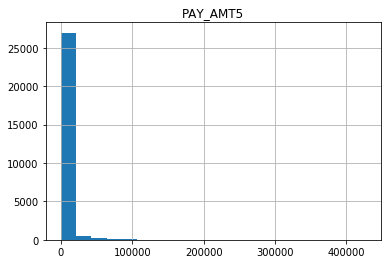

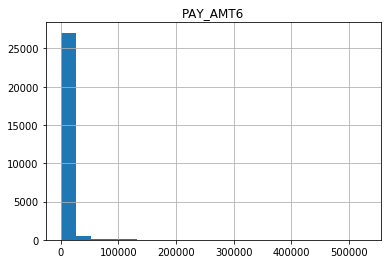

In [13]:
plt.rcParams.update({'figure.max_open_warning': 0}) #deactivate warning

df_temp = df.iloc[:,11:-1]
columns = df_temp.columns.values.tolist()
print(columns)
    
for i in columns:
    df.hist(column=i, bins=20)

## Target
#### As only 16% of our sample consists of clients with default status, our sample is imbalanced

Percentage of defaults in sample:  16.561305760920035


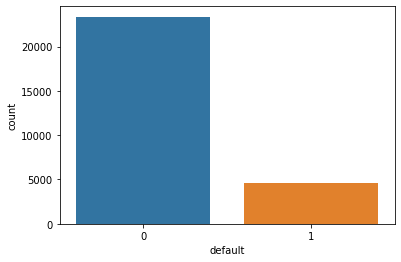

In [14]:
sns.countplot(x='default', data=df)
print('Percentage of defaults in sample: ', df['default'].sum()/df['default'].count()*100)

## Metric selection
#### Overall, accuracy is a great metric to evaluate a binary classification model, although this measure would not be good for our model since an imbalanced training sample would causes a biased model.
#### We could use recall or precission as a metric for evaluating models trained with an imbalanced data set.
#### Since we are more interested in reducing the Type 2 Error (false negative) (clients that will default and were predicted not to), it would be more appropriate to use the recall score.

## Preprocessing datasets
#### As we are dealing with categorical features and not all models are able to handle these, we will create a new dataset, df2, that will replace these categorical features by dummies (binary features). We will not take "PAY" features into account as this would add a lot of features. We will come back to this step if deemed necessary. 

In [15]:
df2 = df
df2['SEX'] = df2['SEX']-1
marriage = pd.get_dummies(df2['MARRIAGE'], drop_first=True)
marriage.columns = ['MAR1','MAR2','MAR3']

education = pd.get_dummies(df2['EDUCATION'], drop_first=True)
education.columns = ['ED1','ED2','ED3','ED4', 'ED5', 'ED6']

df2 = pd.concat([df2,marriage,education],axis=1)

df2.drop(['MARRIAGE', 'EDUCATION'], axis=1, inplace=True)


#### Defining features and target

In [16]:
X=df.drop(['default'], axis=1)       # includes categorical features
X2 = df2.drop(['default'], axis=1)   # includes dummies

y=df['default']

####  Defining test and train subsets for each datset variation

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.1, random_state=42)

##  
## Modeling
#### We will start by using simple models trained with our original imbalanced training set

### Logistic Regression

In [18]:
logit = LogisticRegression(max_iter=1000, random_state=42)
logit_pipe = Pipeline([('scaler', StandardScaler()), ('logit', logit)])

In [19]:
%%time
logit_pipe.fit(X2_train,y2_train)

pipe_pred = logit_pipe.predict(X2_test)
pipe_train_pred = logit_pipe.predict(X2_train)

CPU times: user 1.44 s, sys: 47.8 ms, total: 1.49 s
Wall time: 413 ms


In [20]:
print('Confusion matrix:')
confusion_matrix(y2_test, pipe_pred)

Confusion matrix:


array([[2351,   29],
       [ 369,   51]])

In [21]:
print('Train score: ', accuracy_score(y2_train, pipe_train_pred))
print('Test score: ', accuracy_score(y2_test, pipe_pred))
print('Recall score: ', recall_score(y2_test, pipe_pred))

Train score:  0.8440017461010357
Test score:  0.8578571428571429
Recall score:  0.12142857142857143


#### This last accuracy score means we predicted the right outcome 85% of the time, very little above what we would have gotten by predicting that no client would default. We can easily tell this model is not good enough.
####  

### Random Forest
#### In this model, the variability that is introduced by using multiple bootstrapped datasets and random variable selection make random forests better models than a simple decision tree

In [22]:
f_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)

In [23]:
%%time
f_forest.fit(X2_train,y2_train)

f_forest_train_pred = f_forest.predict(X2_train)
f_forest_pred = f_forest.predict(X2_test)

CPU times: user 9.41 s, sys: 191 ms, total: 9.6 s
Wall time: 2.62 s


In [24]:
print('Confusion matrix:')
confusion_matrix(y2_test, f_forest_pred)

Confusion matrix:


array([[2315,   65],
       [ 300,  120]])

In [25]:
print('Train score: ', accuracy_score(y2_train, f_forest_train_pred))
print('Test score: ', accuracy_score(y2_test, f_forest_pred))
print('Recall score: ', recall_score(y2_test, f_forest_pred))

Train score:  0.9996825270844081
Test score:  0.8696428571428572
Recall score:  0.2857142857142857


#### Although we obtain a better score, our model is not fitted enough.
#### We can improve recall and accuracy by implementing an algorithm such as Adaptive Boosting that will add weight to weak learners so that the model is tweaked to fit these better.
#### Other similar methods that are more efficient at this are XGBoost, LightBGM and CatBoost.

#### Calculating the Gini importance to rank features from most to least important (10 most relevant)
#### We notice that the most important feature is a categorical one. Handling this type of feature in a model that allows it like LightGBM should improve our result. We can also try XGBoost in which we can easily increase fit by increasing the max_depth parameter

In [26]:
pd.DataFrame(f_forest.feature_importances_,
             index=X2_train.columns,
             columns=['Importance']).sort_values(by="Importance", ascending=False)[:10]

,Importance
PAY_0,0.096486
AGE,0.065243
LIMIT_BAL,0.059367
BILL_AMT1,0.059063
BILL_AMT2,0.055086
BILL_AMT3,0.051979
PAY_AMT1,0.051602
BILL_AMT5,0.050463
BILL_AMT6,0.050461
BILL_AMT4,0.050161


### LightGBM (no tuning)

In [27]:
lgbmC = LGBMClassifier(random_state=42, learning_rate=0.1)

In [28]:
%%time
lgbmC.fit(X_train,y_train, categorical_feature='auto')

CPU times: user 2.27 s, sys: 95 ms, total: 2.36 s
Wall time: 346 ms


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [29]:
print('Train score: ', accuracy_score(y_train, lgbmC.predict(X_train)))
print('Test score: ', accuracy_score(y_test, lgbmC.predict(X_test)))
print('Recall score: ', recall_score(y_test, lgbmC.predict(X_test)))

Train score:  0.8778522957260209
Test score:  0.8728571428571429
Recall score:  0.3119047619047619


#### Not very different scores from RandomForest

### LightGBM: tuning model complexity
#### We will tune num_leaves and max_depth in order to find a better fit

In [30]:
param_grid = {'num_leaves': [7,15,31,63],
              'max_depth': [3,4,5,6,-1]}

grid_searcher = GridSearchCV(estimator=lgbmC, param_grid=param_grid, cv=5, verbose=1, n_jobs=4)
grid_searcher.fit(X_train,y_train)

print(grid_searcher.best_params_, grid_searcher.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   16.1s finished


{'max_depth': 4, 'num_leaves': 15} 0.8568992020966618


In [31]:
print('Train accuracy: ', accuracy_score(y_train, grid_searcher.predict(X_train)))
print('Test accuracy: ', accuracy_score(y_test, grid_searcher.predict(X_test)))
print('Test recall: ', recall_score(y_test, grid_searcher.predict(X_test)))

Train accuracy:  0.8668597960236517
Test accuracy:  0.8732142857142857
Test recall:  0.3119047619047619


### XGBoost (no tuning)

In [32]:
xgbC = XGBClassifier()

In [33]:
%%time
xgbC.fit(X2_train, y2_train)

xgbC_pred = xgbC.predict(X2_test)
xgbC_train_pred = xgbC.predict(X2_train)

CPU times: user 15.5 s, sys: 365 ms, total: 15.8 s
Wall time: 2.35 s


In [34]:
print('Train accuracy: ', accuracy_score(y2_train, xgbC_train_pred))
print('Test accuracy:  ', accuracy_score(y2_test, xgbC_pred))
print('Test recall: ', recall_score(y2_test, xgbC_pred))

Train accuracy:  0.9103932695741894
Test accuracy:   0.8685714285714285
Test recall:  0.3119047619047619


#### Tweaking max depth to fit the model

In [35]:
xgbC = XGBClassifier(max_depth=20)

In [36]:
%%time
xgbC.fit(X2_train, y2_train)

xgbC_pred = xgbC.predict(X2_test)
xgbC_train_pred = xgbC.predict(X2_train)

CPU times: user 48.2 s, sys: 724 ms, total: 48.9 s
Wall time: 6.75 s


In [37]:
print('Train accuracy: ', accuracy_score(y2_train, xgbC_train_pred))
print('Test accuracy:  ', accuracy_score(y2_test, xgbC_pred))
print('Test recall: ', recall_score(y2_test, xgbC_pred))

Train accuracy:  0.9988094765665304
Test accuracy:   0.8628571428571429
Test recall:  0.3119047619047619


#### After tweaking max_depth we get a model that is better fitted but still biased
#### We will handle the imbalanced data set with two simple methods and check the results

### XGBoost: handling imbalaced dataset by under sampling
#### This method will help us balance our dataset by selecting random samples of negative defaults to match the amount of positive defaults

In [38]:
df2_X = df2.drop(['default'], axis=1)
df2_y = df2['default']

default = df2[df2['default']==1]
normal = df2[df2['default']==0]

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X2_under, y2_under = rus.fit_sample(df2_X,df2_y)

X2_under_train, X2_under_test, y2_under_train, y2_under_test = train_test_split(X2_under, y2_under, test_size=0.1, random_state=1)

#### In the previous last step we obtain the training and testing subsets from the balanced dataset (only the training subset is used in further steps)

In [39]:
xgbC = XGBClassifier(max_depth=20)

In [40]:
%%time
xgbC.fit(X2_under_train, y2_under_train)

xgbC_pred = xgbC.predict(X2_test)
xgbC_train_pred = xgbC.predict(X2_train)

CPU times: user 15.9 s, sys: 318 ms, total: 16.2 s
Wall time: 2.29 s


In [41]:
print('Train accuracy: ', accuracy_score(y2_train, xgbC_train_pred))
print('Test accuracy:  ', accuracy_score(y2_test, xgbC_pred))
print('Test recall:    ', recall_score(y2_test, xgbC_pred))

Train accuracy:  0.806182785031152
Test accuracy:   0.8139285714285714
Test recall:     0.9761904761904762


#### These accuracy results seem worse than the last ones, but they are not biased so they are a better metric. Also, we have a much larger recall

### XGBoost: handling imbalaced dataset by over sampling
#### This method will help us balance our dataset by selecting random samples of positive defaults to match the amount of negative defaults (this will generate duplicate entries in the dataset). Bias should be reduced with this new sample and hopefully it will not cause overfitting.

In [42]:
df2_X = df2.drop(['default'], axis=1)
df2_y = df2['default']

default = df2[df2['default']==1]
normal = df2[df2['default']==0]

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X2_over, y2_over = ros.fit_sample(df2_X,df2_y)

X2_over_train, X2_over_test, y2_over_train, y2_over_test = train_test_split(X2_over, y2_over, test_size=0.1, random_state=1)

#### We obtain our new subset X2_over_train, y2_over_train from the previous last step

In [43]:
xgbC = XGBClassifier(max_depth=20)

In [44]:
%%time
xgbC.fit(X2_over_train, y2_over_train)
    
xgbC_pred = xgbC.predict(X2_test)
xgbC_train_pred = xgbC.predict(X2_train)

CPU times: user 1min 15s, sys: 936 ms, total: 1min 16s
Wall time: 10.5 s


In [45]:
print('Train accuracy: ', accuracy_score(y2_train, xgbC_train_pred))
print('Test accuracy:  ', accuracy_score(y2_test, xgbC_pred))
print('Test recall:    ', recall_score(y2_test, xgbC_pred))

Train accuracy:  0.9921822294535497
Test accuracy:   0.9921428571428571
Test recall:     1.0


#### We could do further tuning to this model but for now we have achieved an accuracy above 98% for both our training and testing subsets. Also, our test recall is very close to 1.

## Predicting default status for validation dataset
#### Now we will import the validation subset, preprocess and run it through our model trained by the new sample

In [46]:
%%time

# IMPORT DATA SET
df = pd.read_csv("validation_dataset.csv")

# DATA WRANGLING
df = df.drop(['ID'], axis=1)

df2 = df
df2['SEX'] = df2['SEX']+7
marriage = pd.get_dummies(df2['MARRIAGE'], drop_first=True)
marriage.columns = ['MAR1','MAR2','MAR3']

## this feature only had values from 2 to 5 this time, so we are accounting for it by adding column 6 with all 0s
education = pd.get_dummies(df2['EDUCATION'], drop_first=False)
education['6'] = 0
education.columns = ['ED1','ED2','ED3','ED4', 'ED5', 'ED6']

df2 = pd.concat([df2,marriage,education],axis=1)

df2.drop(['MARRIAGE', 'EDUCATION'], axis=1, inplace=True)

# DEFINE FEATURES
X2 = df2.drop(['default'], axis=1)

# PREDICT
xgbC_pred = xgbC.predict(X2)              #status
xgbC_pred_proba = xgbC.predict_proba(X2)  #probabilities

#ADDING PREDICTION TO DATASET
X2['default_pred'] = xgbC_pred
X2.describe()

CPU times: user 1.16 s, sys: 50.2 ms, total: 1.21 s
Wall time: 158 ms


,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,MAR1,MAR2,MAR3,ED1,ED2,ED3,ED4,ED5,ED6,default_pred
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.00000,2001.000000,...,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2001.0,2001.000000
mean,137211.394303,8.550725,35.496752,0.635682,0.363818,0.333333,0.161919,0.123938,0.06097,48415.934533,...,0.468266,0.518741,0.012494,0.341829,0.478261,0.177411,0.000500,0.001999,0.0,0.341829
std,118604.467834,0.497545,9.886259,1.377210,1.525638,1.555742,1.473014,1.465821,1.47081,73427.295418,...,0.499117,0.499774,0.111103,0.474441,0.499652,0.382112,0.022355,0.044677,0.0,0.474441
min,10000.000000,8.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.00000,-3928.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,50000.000000,8.000000,27.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,2500.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,100000.000000,9.000000,34.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,20184.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,200000.000000,9.000000,42.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.00000,58143.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000
max,710000.000000,9.000000,73.000000,8.000000,7.000000,8.000000,8.000000,8.000000,8.00000,581775.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


## Calculating expected portfolio loss
#### We have various billing amounts and payment amounts. We will calculate de owed amount by subtracting the sum of payment amounts from the sum of billing amounts.
#### Next, we will multiply the owed amount of each client by the probability of going to default. This is the expected loss per client.
#### Finally, we will add all these expected losses to get the expected loss of the portfolio (validation dataset)
#### The final amount units assume we are working with cents.

In [47]:
X2['BILL_SUM'] = X2['BILL_AMT1'] + X2['BILL_AMT2'] + X2['BILL_AMT3'] + X2['BILL_AMT4'] + X2['BILL_AMT5'] + X2['BILL_AMT6']
X2['PAY_SUM'] = X2['PAY_AMT1'] + X2['PAY_AMT2'] + X2['PAY_AMT3'] + X2['PAY_AMT4'] + X2['PAY_AMT5'] + X2['PAY_AMT6']
X2['OWED_AMT'] = X2['BILL_SUM'] - X2['PAY_SUM']

expected_loss = []
for i in range(len(X2)):
    expected_loss.append(X2['OWED_AMT'][i]*xgbC_pred_proba[i][1])    
print('Assuming that we are using our model in order to predict which of these current clients (in the validation dataset) will go to default, we are expected to lose USD',
       round(sum(expected_loss)/100,2))

Assuming that we are using our model in order to predict which of these current clients (in the validation dataset) will go to default, we are expected to lose USD 2050699.5
